In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
from tqdm import tqdm


## Data preprocess

In [119]:
TRAIN_PATH = './kaggle/input/tabular-playground-series-aug-2022/train.csv'
TEST_PATH = './kaggle/input/tabular-playground-series-aug-2022/test.csv'

df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

df_train.head()


,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [120]:
print(df_train['attribute_0'].value_counts())
df_train['attribute_0'] = df_train['attribute_0'].map({'material_5': 5, 'material_7': 7})


material_7    21320
material_5     5250
Name: attribute_0, dtype: int64


In [121]:
print(df_train['attribute_1'].value_counts())
df_train['attribute_1'] = df_train['attribute_1'].map({'material_5': 5, 'material_6': 6, 'material_8': 8})


material_8    10865
material_5    10362
material_6     5343
Name: attribute_1, dtype: int64


In [122]:
print(df_test['attribute_0'].value_counts())
df_test['attribute_0'] = df_test['attribute_0'].map({'material_5': 5, 'material_7': 7})


material_5    10529
material_7    10246
Name: attribute_0, dtype: int64


In [123]:
print(df_test['attribute_1'].value_counts())
df_test['attribute_1'] = df_test['attribute_1'].map({'material_5': 5, 'material_6': 6, 'material_7': 7})


material_6    10529
material_5     5228
material_7     5018
Name: attribute_1, dtype: int64


In [124]:
for col in df_train.columns:
    null_count = df_train[col].isnull().sum()
    if null_count > 0:
        print(f'{col} has {null_count} null values')


loading has 250 null values
measurement_3 has 381 null values
measurement_4 has 538 null values
measurement_5 has 676 null values
measurement_6 has 796 null values
measurement_7 has 937 null values
measurement_8 has 1048 null values
measurement_9 has 1227 null values
measurement_10 has 1300 null values
measurement_11 has 1468 null values
measurement_12 has 1601 null values
measurement_13 has 1774 null values
measurement_14 has 1874 null values
measurement_15 has 2009 null values
measurement_16 has 2110 null values
measurement_17 has 2284 null values


In [125]:
# combine attribute_2 and attribute_3
df_train['Area'] = df_train['attribute_2'] * df_train['attribute_3']
df_test['Area'] = df_test['attribute_2'] * df_test['attribute_3']

for col in df_train.columns:
    if col.startswith("measurement"):
        df_train[col] = df_train[col].fillna(df_train[col].mean())
        df_train[col] = df_train[col] / df_train['Area']
        df_test[col] = df_test[col].fillna(df_test[col].mean())
        df_test[col] = df_test[col] / df_test['Area']

df_train = df_train.drop(['Area'], axis=1)
df_test = df_test.drop(['Area'], axis=1)

original_train = df_train.copy()
original_test = df_test.copy()

df_train.head()


,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,7,8,9,5,0.155556,0.177778,0.088889,...,0.237156,0.352422,0.390978,0.337622,0.333978,0.356632,0.289644,0.326311,16.980000,0
1,1,A,84.89,7,8,9,5,0.311111,0.066667,0.066667,...,0.276622,0.398822,0.398111,0.261222,0.327378,0.342778,0.319889,0.347356,15.156822,0
2,2,A,82.43,7,8,9,5,0.266667,0.022222,0.111111,...,0.282556,0.346822,0.426046,0.306622,0.371356,0.414022,0.313200,0.398800,14.741689,0
3,3,A,101.07,7,8,9,5,0.288889,0.044444,0.133333,...,0.277133,0.363244,0.408378,0.222667,0.338889,0.345822,0.358978,0.381600,18.361822,0
4,4,A,188.06,7,8,9,5,0.200000,0.044444,0.177778,...,0.229711,0.379600,0.442933,0.276178,0.359600,0.283556,0.292289,0.364711,12.886333,0


In [126]:
skip_cols = ['id', 'product_code', 'failure']
for col in df_train.columns:
    # normalize the data (note that I normalize test set with train set's mean and std)
    if col not in skip_cols and not col.startswith('attribute'):
        df_test[col] = (df_test[col] - df_train[col].mean()) / df_train[col].std()
        df_train[col] = (df_train[col] - df_train[col].mean()) / df_train[col].std()
        # replace NaN with 0
        df_train[col].fillna(0, inplace=True)
        df_test[col].fillna(0, inplace=True)
        original_train[col].fillna(0, inplace=True)
        original_test[col].fillna(0, inplace=True)

df_train.head()


,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,-1.222808,7,8,9,5,-0.100033,-0.025848,-0.603036,...,-0.231855,-0.003948,-0.316651,1.421670,-0.107972,0.075125,-0.519805,-0.410888,0.411850,0
1,1,A,-1.100082,7,8,9,5,1.408407,-1.117482,-0.888028,...,0.496427,0.580318,-0.234210,0.105886,-0.201951,-0.102616,-0.103418,-0.152464,-0.039927,0
2,2,A,-1.163111,7,8,9,5,0.977424,-1.554135,-0.318044,...,0.605915,-0.074463,0.088644,0.887779,0.424255,0.811399,-0.195507,0.479268,-0.142795,0
3,3,A,-0.685530,7,8,9,5,1.192916,-1.335809,-0.033051,...,0.505858,0.132325,-0.115555,-0.558129,-0.038042,-0.063558,0.434734,0.268054,0.754260,0
4,4,A,1.543268,7,8,9,5,0.330950,-1.335809,0.536933,...,-0.369227,0.338273,0.283811,0.363455,0.256866,-0.862394,-0.483398,0.060660,-0.602545,0


In [127]:
train_x = df_train.drop(['id', 'product_code', 'attribute_2', 'attribute_3', 'failure'], axis=1).to_numpy()
train_y = df_train['failure'].to_numpy()


test_x = df_test.drop(['id', 'product_code', 'attribute_2', 'attribute_3'], axis=1).to_numpy()

original_train_x = original_train.drop(['id', 'product_code', 'attribute_2', 'attribute_3', 'failure'], axis=1).to_numpy()
original_train_y = original_train['failure'].to_numpy()

original_test_x = original_test.drop(['id', 'product_code', 'attribute_2', 'attribute_3'], axis=1).to_numpy()

print("train_x shape:", train_x.shape)
print("test_x shape:", test_x.shape)


train_x shape: (26570, 21)
test_x shape: (20775, 21)


In [128]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
import pickle

pca = PCA(n_components=0.95)
new_train_x = pca.fit_transform(train_x)
new_test_x = pca.transform(test_x)


from imblearn.over_sampling import SMOTE 
smt = SMOTE()
new_train_x, train_y = smt.fit_resample(new_train_x, train_y)
original_train_x, original_train_y = smt.fit_resample(original_train_x, original_train_y)

print(sum(train_y == 0), sum(train_y == 1))


print("new_train_x shape:", new_train_x.shape)
print("new_test_x shape:", new_test_x.shape)

pickle.dump(pca, open('pt.pkl', 'wb'))
pickle.dump(new_test_x, open('new_test_x.pkl', 'wb'))
pickle.dump(original_test_x, open('original_test_x.pkl', 'wb'))


20921 20921
new_train_x shape: (41842, 12)
new_test_x shape: (20775, 12)


## Training

### Logistic Regression

In [129]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import joblib

x_train, x_val, y_train, y_val = train_test_split(new_train_x, train_y, test_size=0.2)

clf = linear_model.LogisticRegression(max_iter=5000, C=1e-3, solver='saga', penalty='elasticnet', l1_ratio= 1e-3, tol=1e-2, class_weight='balanced')
clf.fit(x_train, y_train)

y_pred = clf.predict(x_val)
print(sum(y_pred))

ruc_score = roc_auc_score(y_val, y_pred)
print("ROC Accuracy:", roc_auc_score(y_val, y_pred))

joblib.dump(clf, 'model.pkl')


3761
ROC Accuracy: 0.56967795585986


['model.pkl']

Text(0.5, 1.0, 'Confusion Matrix')

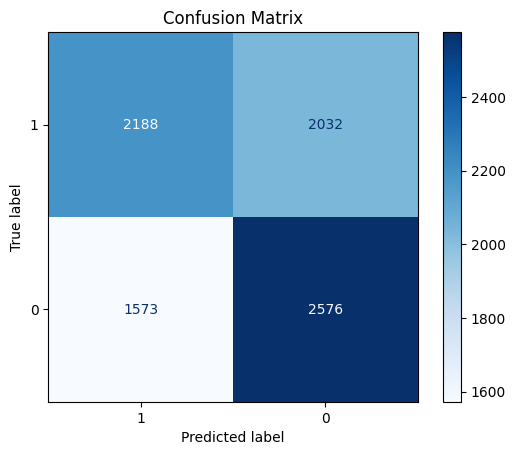

In [130]:
from sklearn import metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred, labels = (1,0), normalize = None, cmap='Blues')
disp.ax_.grid(False)
disp.ax_.set_title('Confusion Matrix')

### AdaBoost

In [131]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

x_train, x_val, y_train, y_val = train_test_split(original_train_x, original_train_y, test_size=0.2)

clf = ensemble.AdaBoostClassifier(n_estimators=300, learning_rate=0.1)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_val)
print(sum(y_pred))

ruc_score = roc_auc_score(y_val, y_pred)
print("ROC Accuracy:", roc_auc_score(y_val, y_pred))

joblib.dump(clf, 'model.pkl')


4321
ROC Accuracy: 0.6260469363768342


['model.pkl']

Text(0.5, 1.0, 'Confusion Matrix')

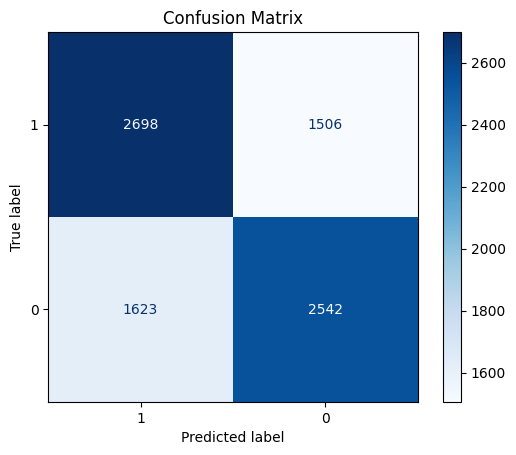

In [132]:
from sklearn import metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred, labels = (1,0), normalize = None, cmap='Blues')
disp.ax_.grid(False)
disp.ax_.set_title('Confusion Matrix')

### Random forest

In [140]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

x_train, x_val, y_train, y_val = train_test_split(original_train_x, original_train_y, test_size=0.2)

clf = ensemble.RandomForestClassifier(n_estimators=500, max_depth=10, bootstrap=True, n_jobs=-1, class_weight='balanced')
clf.fit(x_train, y_train)

y_pred = clf.predict(x_val)
print(sum(y_pred))

ruc_score = roc_auc_score(y_val, y_pred)
print("ROC Accuracy:", roc_auc_score(y_val, y_pred))

joblib.dump(clf, 'model.pkl')


4363
ROC Accuracy: 0.709464086690313


['model.pkl']

Text(0.5, 1.0, 'Confusion Matrix')

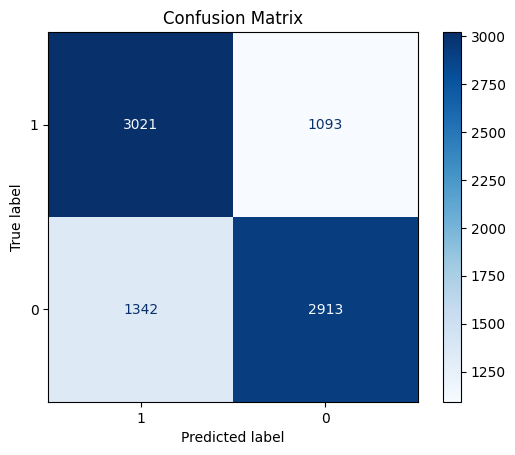

In [142]:
from sklearn import metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred, labels = (1,0), normalize = None, cmap='Blues')
disp.ax_.grid(False)
disp.ax_.set_title('Confusion Matrix')

### SVC

In [ ]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer


para = {'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}

svc = SVC()

RS = RandomizedSearchCV(svc, para, cv=5, n_jobs=-1, verbose=3, scoring='roc_auc')

RS.fit(x_train, y_train)

print(RS.best_estimator_, RS.best_score_)


In [ ]:
y_pred = RS.predict(x_val)


In [ ]:
from sklearn import metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred, labels = (1,0), normalize = None, cmap='Blues')
disp.ax_.grid(False)
disp.ax_.set_title('Confusion Matrix')

### NN(?)

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


model = nn.Sequential(
    nn.Linear(10, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

model.to(device)

for epoch in range(100):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    optimizer.zero_grad()
    x = torch.from_numpy(x_train).float().to(device)
    y = torch.from_numpy(y_train).float().to(device)
    y_pred = model(x)
    loss = F.binary_cross_entropy(y_pred, y)
    loss.backward()
    optimizer.step()
    print(f'Epoch: {epoch}, Loss: {loss.item()}')

    